# Music Generation with GANs and Autoencoders

## Collin Dabbieri & Collin McLeod

### Appendix - Dabbieri

Here I'll provide additional information not covered in the final talk for the GAN side of the project

In [57]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import glob
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout, Activation, Conv2D, Flatten, Reshape, Conv2DTranspose, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import RMSprop

FONTSIZE=18

plt.rcParams['figure.figsize']=(15,8)
plt.rcParams['font.size']=FONTSIZE

#load in training data
fp = open('../WassGAN/ins_convgan_final_fantasy_fifths.pkl', "rb")
ins = pickle.load(fp)
fp.close()

# Clipping Pitches to Create Square Images

I set each image to have 96 columns because this divides all common time signatures well. In order to create a square image I cut out lower pitches which rarely occur in the training data. A histogram of removed pitches is given below.

![PitchClip](./Pitch_hist.png)

# Minor Fifths Mapping

At first I used what I called a linear mapping system, where moving up 1 pixel corresponded to moving up a half-step in pitch (ex. C -> C#). In an attempt to incorporate musical locality, I decided on a mapping system where moving up 1 pixel corresponds to moving up a Minor fifth. This meant that I had to remove all songs from the training data in a major key, as a major fifth is a different number of half steps than a minor fifth. I chose a minor fifth as opposed to a major fifth because the final fantasy MIDI set had more songs in a minor key. Luckily music21 has algorithms designed to identify the key of any MIDI file, so this was not difficult. I've included a plot explaining the fifths mapping system below. Each plot shows a C chord, then an F chord and finally a G chord. Interestingly if you wanted to show a Cminor, Fminor, and Gminor in the minor fifths mapping, it would have the same shape but flipped across the y-axis (From a C chord to a Cminor chord, the note E becomes D#).

![LinearMapping](../ConvGAN/presentation/linear_mapping_small.png)

![FifthsMapping](../ConvGAN/presentation/fifths_mapping_small2.png)

# Image Channels

I was worried that if each training sample only contained one measure, the images would not cover enough time to produce anything interesting. To alleviate this, I decided to treat image channels as a continuation of the time domain. So the first channel gets the first measure, the second channel gets the second measure, and so on. To increase the amount of training data available, training samples stride by 1 measure, so the first sample gets measures 1,2,3 and 4, the second sample gets measures 2,3,4,5, and so on. 

This is one area where I feel the project was really successful. In the audio files played in my section of the final talk, it was clear that the generator was restating a musical idea in a new way from one measure (channel) to the next.

# Octave Stride in the y-axis

It is common practice to upsample your latent space with a fully connected layer to some low dimensional representation of your final generated image. This low dimensional representation can then be expanded using Conv2DTranspose layers to the desired image size. Because we want our generator to stride an octave in the y-axis, but we don't want that behavior in our x-axis, it is beneficial to create a nonsquare low dimensional representation of the image with the initial fully-connected layer. This means the user has to specify the low-dimensional starting image size, y strides, x strides, y kernal sizes and x kernal sizes. There is also the added constraint that the final generated image must be the correct size, and that kernal sizes are factors of kernal strides. These checks are written into the script in the check_args section of your base argparse template. An example of a generator architecture with octave stride in the y and a low dimensional nonsquare starting image is given below.

In [59]:
#########################################################
# Parameters that would normally be caught in a parser
generator_starting_shape=[4,12] #rows by columns
generator_filters=[48,48,48]
generator_kernel_height=[12,2]
generator_kernel_width=[2,4]
generator_stride_height=[12,2]
generator_stride_width=[2,4]
latent_dim=20
load_pretrained=False
init_weight_sigma=0.02
num_channels=4


#########################################################
def build_generator():
    '''
    init_weight_sigma - standard deviation for initialized weight values
    generator_filters - list of filters for the initial dense layer and the subsequent Conv2DTranspose layers
    generator_starting_shape - (rows,columns) size of Dense layer image upsampled from latent space
    generator_kernel_height - list with heights of conv kernels
    generator_kernel_width - list with widths of conv kernels
    generator_stride_height - list with heights of conv strides
    generator_stride_width - list with widths of conv strides
    '''
    if not load_pretrained:
        init=RandomNormal(stddev=init_weight_sigma)

        model=Sequential()

        for i in range(len(generator_filters)):

            if i==0:
                #first we upsample the latent space to a single dense layer
                n_nodes=generator_starting_shape[0]*generator_starting_shape[1]*generator_filters[i]
                model.add(Dense(units=n_nodes,
                                kernel_initializer=init,
                                input_dim=latent_dim,
                                name='Generator_Dense'))
                model.add(LeakyReLU(alpha=0.2))
                model.add(Reshape((generator_starting_shape[0],generator_starting_shape[1],generator_filters[i])))

            else:
                #kernel size should be a factor of the stride size
                model.add(Conv2DTranspose(filters=generator_filters[i],
                                          kernel_size=(generator_kernel_height[i-1],generator_kernel_width[i-1]),
                                          strides=(generator_stride_height[i-1],generator_stride_width[i-1]),
                                          padding='same',
                                          kernel_initializer=init,
                                          name='Generator_Conv_'+str(i)
                                          ))
                model.add(LeakyReLU(alpha=0.2))

        #collapse it back to one image
        model.add(Conv2D(filters=num_channels,
                         kernel_size=(7,7),
                         activation='tanh',
                         padding='same',
                         kernel_initializer=init))
        
    elif load_pretrained:
        
        model=load_model(pretrained_gen_name)
        
    print(model.summary())
    
    return model

model=build_generator()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator_Dense (Dense)      (None, 2304)              48384     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 2304)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 12, 48)         0         
_________________________________________________________________
Generator_Conv_1 (Conv2DTran (None, 48, 24, 48)        55344     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 48, 24, 48)        0         
_________________________________________________________________
Generator_Conv_2 (Conv2DTran (None, 96, 96, 48)        18480     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 96, 96, 48)       

# Converting Generated Images to MIDIs

In order to use music21 to generate a MIDI file, you need to collect lists with the pitch, time (offset), and duration of each note. This was actually nontrivial, because if adjacent pixels in the same row were activated, you would want them to be treated as a single note with a longer duration. To avoid boring you with all of the code, I've attached a snippet that handles this problem below

In [ ]:
offsets=[]
pitches=[]
durations=[]
for row in range(image.shape[0]): #image is our generated image (shape (96,96,4)) reshaped to (96,96*4)

    note_previous=False #this will help us fill durations, does the previous column in this row contain a note?

    for column in range(image.shape[1]):

        offset=pixel_length*column #pixel length is the duration (in time) of one pixel
        pitch=pitch_dict[row] #this is a dictionary that converts row value to the pitch ex. 32->C#

        if image[row,column]>=confidence: #confidence is the threshold at which we consider a pixel value to constitute a note
            #we have a note at this pixel

            if note_previous:
                # the current pixel is a continuation of a previous note
                durations[-1]+=pixel_length

            elif not note_previous:
                # the current pixel is the start of a new note
                offsets.append(offset)
                pitches.append(pitch)
                durations.append(pixel_length) 

            note_previous=True
        else:
            note_previous=False

# WassGAN

Arjovsky et al. 2017 recommend the following hyperparameter values as defaults

- learning rate=0.00005 with no momentum (so RMSprop instead of Adam optimizer)
- clipping parameter=0.01
- batch size=64
- critic boost=5


Using these parameters caused the generator to dominate the discriminator in classifying fake images as shown in the talk (first loss plot for WGAN)
Eventually a critic boost of 10 and a weight clip of 0.001 proved to train well. Below are some other attempted hyperparameter sets, adjusting critic boost and weight clip values from their defaults


## Critic Boost 10, Weight Clip 0.01

In [3]:
fp=open('../WassGAN/results_boost10_clip0.01/WassGan_fifths_Gfilters_48_48_48_Cfilters_64_64_Gstrides_12-2_2-4_Cstrides_2_2_Cboost_10_results_e750.pkl','rb')
#formerly results2/
#in oscer also results2/
results=pickle.load(fp)
fp.close()

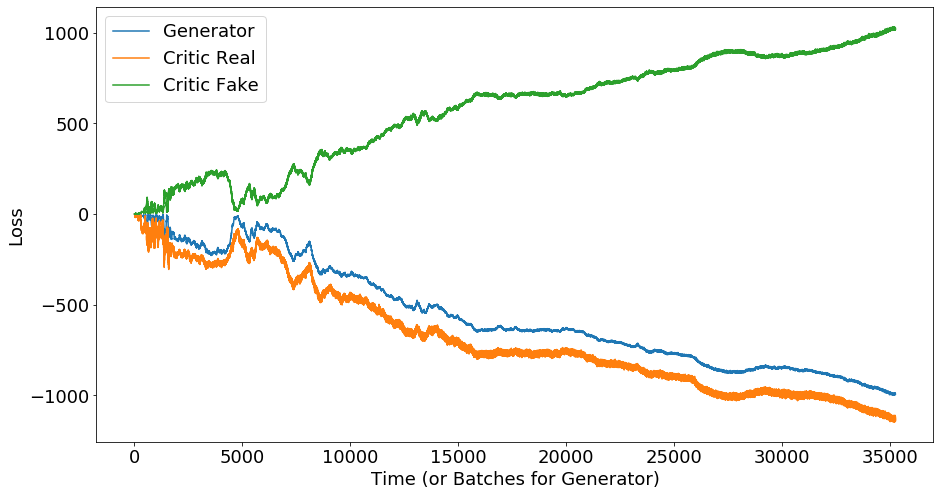

In [4]:
critic_boost=10

gen_loss=results['generator_loss']
critic_real_loss=results['critic_real_loss']
critic_fake_loss=results['critic_fake_loss']

batches=np.arange(len(gen_loss))
batches_critic=np.arange(len(critic_real_loss))/critic_boost
plt.plot(batches,gen_loss,label='Generator')
plt.plot(batches_critic,critic_real_loss,label='Critic Real')
plt.plot(batches_critic,critic_fake_loss,label='Critic Fake')
plt.xlabel('Time (or Batches for Generator)')
plt.ylabel('Loss')
plt.legend(loc='best')

This run shows interesting behavior around 5000 batches but ultimately the generator still dominates

# Critic Boost 10, Weight Clip 0.1

In [5]:
fp=open('../WassGAN/results_boost10_clip0.1/WassGan_fifths_Gfilters_48_48_48_Cfilters_64_64_Gstrides_12-2_2-4_Cstrides_2_2_Cboost_10_WeightClip_0.1_results_e650.pkl','rb')
results=pickle.load(fp)
fp.close()

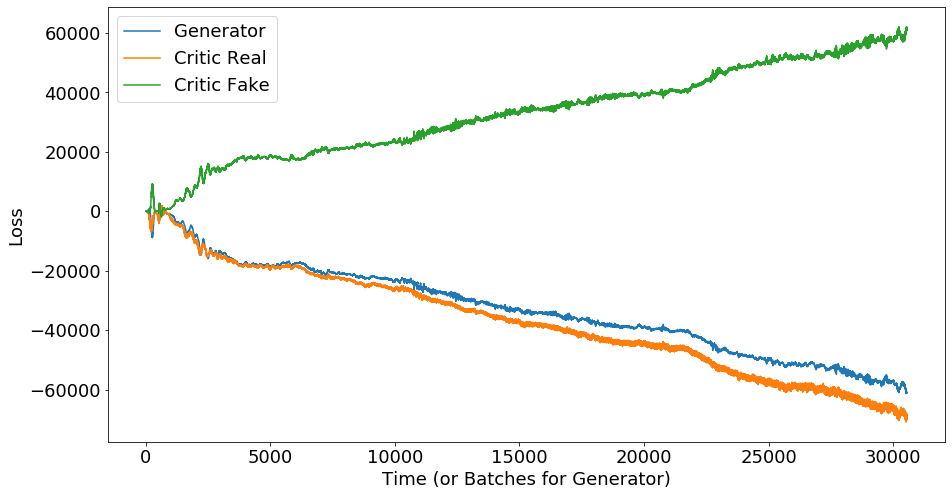

In [6]:
critic_boost=10

gen_loss=results['generator_loss']
critic_real_loss=results['critic_real_loss']
critic_fake_loss=results['critic_fake_loss']

batches=np.arange(len(gen_loss))
batches_critic=np.arange(len(critic_real_loss))/critic_boost
plt.plot(batches,gen_loss,label='Generator')
plt.plot(batches_critic,critic_real_loss,label='Critic Real')
plt.plot(batches_critic,critic_fake_loss,label='Critic Fake')
plt.xlabel('Time (or Batches for Generator)')
plt.ylabel('Loss')
plt.legend(loc='best')

As expected this run fails to train well. Allowing the critic to produce larger weights (and thus larger gradients) gives the generator an increased advantage in training. As it already had an advantage in the previous run, it makes sense that the generator would dominate this run.

# Critic Boost 15, Weight Clip 0.01

In [7]:
fp=open('../WassGAN/results_boost15_clip0.01/WassGan_fifths_Gfilters_48_48_48_Cfilters_64_64_Gstrides_12-2_2-4_Cstrides_2_2_Cboost_15_WeightClip_0.01_results_e550.pkl','rb')
results=pickle.load(fp)
fp.close()

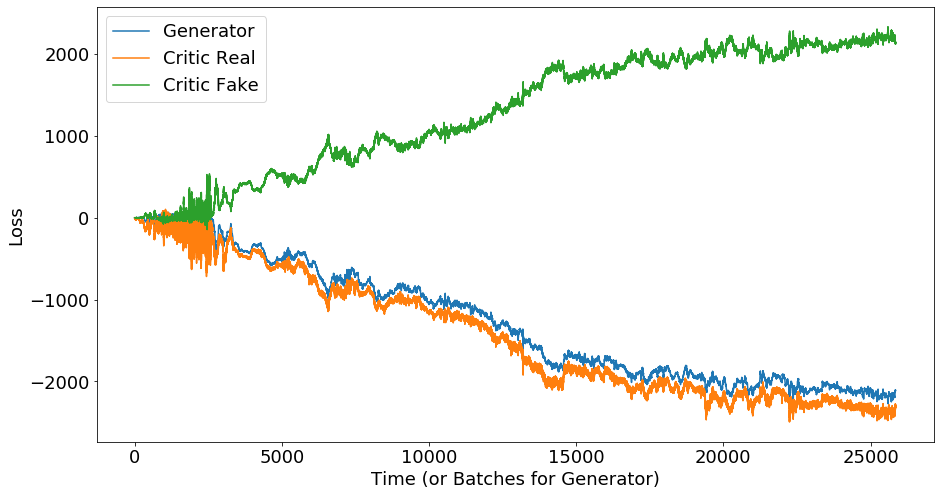

In [8]:
critic_boost=15

gen_loss=results['generator_loss']
critic_real_loss=results['critic_real_loss']
critic_fake_loss=results['critic_fake_loss']

batches=np.arange(len(gen_loss))
batches_critic=np.arange(len(critic_real_loss))/critic_boost
plt.plot(batches,gen_loss,label='Generator')
plt.plot(batches_critic,critic_real_loss,label='Critic Real')
plt.plot(batches_critic,critic_fake_loss,label='Critic Fake')
plt.xlabel('Time (or Batches for Generator)')
plt.ylabel('Loss')
plt.legend(loc='best')

we've added an extra boost by training the critic for 5 additional batches for each generator batch, and returned to the default weight clip value, but this run still does not train evenly. This suggests to me that properly setting weight clip values is more important than the critic boost.

## Threshold Values for Generated Images

Unlike the Deep Convolutional GAN, the WassGan does not quickly learn to generate images with either a 0 or 1 at each pixel value. This means that a threshold value must be set by the user where all pixels with values above the threshold are given a value of 1 and all pixels with values below the threshold are given a value of 0. Higher thresholds will create images with fewer notes and vice versa.

In [13]:
generator=load_model('../WassGAN/results_boost10_clip0.001/\
WassGan_fifths_Gfilters_48_48_48_Cfilters_64_64_Gstrides_12-2_2-4_Cstrides_2_2_Cboost_10_WeightClip_0.001_Gen_epoch_750.h5')

In [33]:
def generate_latent_space(latent_dim,sample_size):
    '''
    latent_dim - size of the latent dimenstion
    sample_size - number of samples
    '''
    
    gen_input=np.random.randn(latent_dim*sample_size)
    gen_input=gen_input.reshape((sample_size,latent_dim))
    
    return gen_input

latent_space=generate_latent_space(latent_dim=20,sample_size=100)

In [34]:
generated_plots=generator.predict(latent_space)
print(generated_plots.shape)

(100, 96, 96, 4)


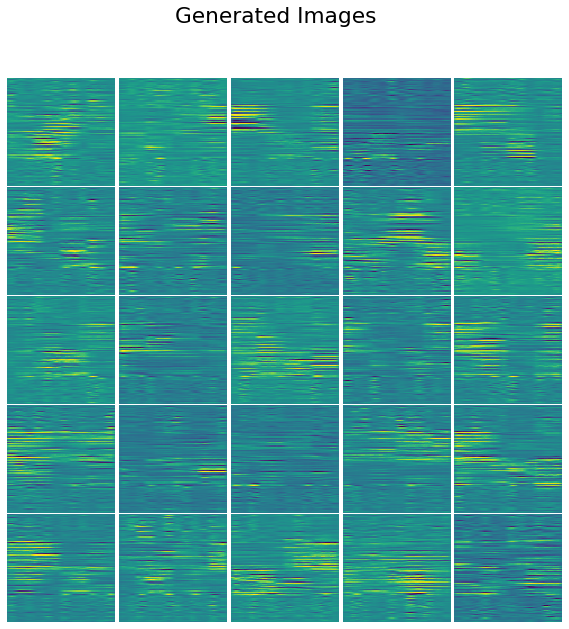

In [35]:
plt.rcParams['figure.figsize']=(10,10)

n=5

fig,axs=plt.subplots(nrows=n,ncols=n)
count=-1
for i in range(n):
    for j in range(n):
        count+=1
        axs[i,j].imshow(generated_plots[count,:,:,0].reshape((96,96)))
        axs[i,j].axis('off')
fig.suptitle("Generated Images")
        
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [50]:
def clip_plots(generated_plots,threshold=0.5):
    
    num_plots=generated_plots.shape[0]
    image_height=generated_plots.shape[1]
    image_width=generated_plots.shape[2]
    num_channels=generated_plots.shape[3]
    
    generated_plots_clipped=np.zeros((num_plots,image_height,image_width,num_channels))
    
    for i in range(num_plots):
        for j in range(image_height):
            for k in range(image_width):
                for m in range(num_channels):
                    
                    pixel_check=generated_plots[i,j,k,m]
                    
                    if pixel_check>threshold:
                        
                        generated_plots_clipped[i,j,k,m]=1
                        
    return generated_plots_clipped

generated_plots_clipped=clip_plots(generated_plots)

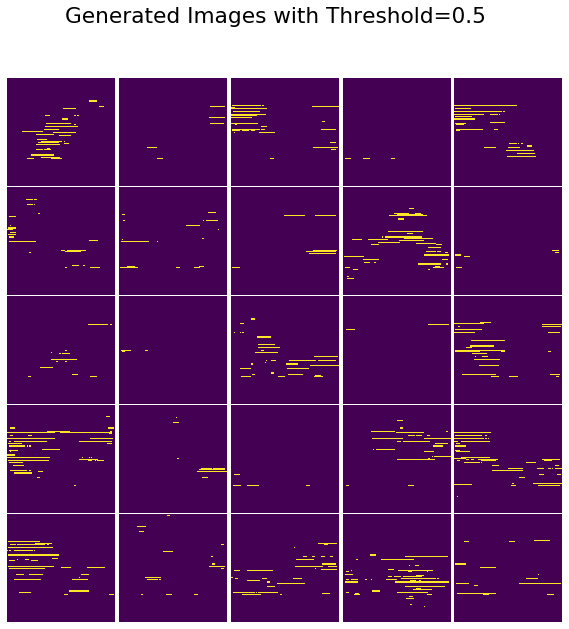

In [52]:
plt.rcParams['figure.figsize']=(10,10)

n=5

fig,axs=plt.subplots(nrows=n,ncols=n)
count=-1
for i in range(n):
    for j in range(n):
        count+=1
        axs[i,j].imshow(generated_plots_clipped[count,:,:,0].reshape((96,96)))
        axs[i,j].axis('off')
fig.suptitle("Generated Images with Threshold=0.5")
        
plt.subplots_adjust(wspace=0.01,hspace=0.01)

## Comparing verbosity of generated images to training data

Here as a sanity check I'm just plotting histograms of the number of activated pixels for each song in the generated data and in the training data. This comparison could be used to determine ideal threshold values.

Although attempting to match the two (setting a threshold value that makes it so the means are aligned) does not make for ideal songs in my experience. Higher thresholds (fewer notes) often lead to more tolerable music.

In [53]:
def count_pixel_activations(images):
    
    num_songs=images.shape[0]
    image_height=images.shape[1]
    image_width=images.shape[2]
    num_channels=images.shape[3]
    
    activations_per_song=[]
    
    for i in range(num_songs):
        
        lit_pixels=0
        
        for j in range(image_height):
            for k in range(image_width):
                for m in range(num_channels):
                    
                    check_pixel=images[i,j,k,m]
                    
                    if check_pixel==1:
                        lit_pixels+=1
                        
        activations_per_song.append(lit_pixels)
        
    return(activations_per_song)


activations_per_gen_song=count_pixel_activations(generated_plots_clipped)
activations_per_real_song=count_pixel_activations(ins)

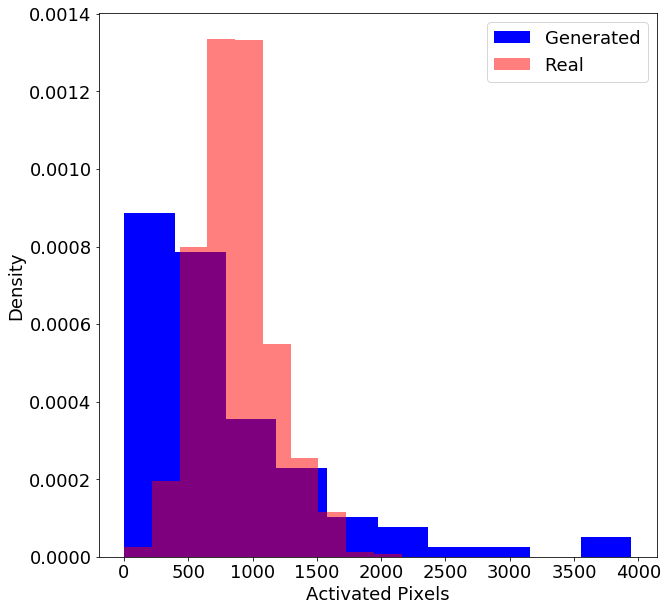

In [55]:
plt.hist(activations_per_gen_song,color='b',label='Generated',density=True)
plt.hist(activations_per_real_song,color='r',alpha=0.5,label='Real',density=True)
#plt.axvline(np.mean(activations_per_gen_song),c='b',label='Generated Mean')
#plt.axvline(np.mean(activations_per_real_song),c='r',label='Real Mean')

plt.xlabel('Activated Pixels')
plt.ylabel('Density')
plt.legend(loc='best')